In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Load your new dataset (Change the filename to match yours)
# df = pd.read_csv('ecommerce_data.csv', encoding='ISO-8859-1')

# First look at the data
# df.head()

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mashlyn/online-retail-ii-uci")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'online-retail-ii-uci' dataset.
Path to dataset files: /kaggle/input/online-retail-ii-uci


In [3]:
import zipfile
import os

zip_path = 'archive (1).zip'
extract_path = 'extracted_files'

# Unzip the file
if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("✅ Extraction Complete!")
    print("Files found in folder:", os.listdir(extract_path))
else:
    print("❌ Could not find 'archive (1).zip'. Make sure it finished uploading in the sidebar.")

✅ Extraction Complete!
Files found in folder: ['online_retail_II.csv']


In [4]:
# 1. Load the extracted file
df = pd.read_csv('extracted_files/online_retail_II.csv', encoding='ISO-8859-1')

# 2. Basic Cleaning for RFM Analysis
# Remove rows without Customer IDs
df = df.dropna(subset=['Customer ID'])

# Remove cancellations (Invoice starts with 'C')
df = df[~df['Invoice'].astype(str).str.contains('C', na=False)]

# Keep only positive quantities and prices
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

# 3. Create the 'TotalAmount' column (Quantity * Price)
df['TotalAmount'] = df['Quantity'] * df['Price']

# 4. Convert InvoiceDate to datetime objects
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print(f"✅ Success! Data loaded with {len(df):,} clean rows.")
print(f"Date range: {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")
display(df.head())

✅ Success! Data loaded with 805,549 clean rows.
Date range: 2009-12-01 07:45:00 to 2011-12-09 12:50:00


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalAmount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [5]:
# Create a snapshot date 1 day after the last transaction
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

print(f"Snapshot Date for analysis: {snapshot_date}")

Snapshot Date for analysis: 2011-12-10 12:50:00


In [6]:
# Aggregate data by Customer ID
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # Recency
    'Invoice': 'nunique',                                   # Frequency
    'TotalAmount': 'sum'                                    # Monetary
})

# Rename columns for clarity
rfm.columns = ['Recency', 'Frequency', 'Monetary']

print("--- Raw RFM Table ---")
display(rfm.head())

--- Raw RFM Table ---


,Recency,Frequency,Monetary
Customer ID,,,
12346.0,326,12,77556.46
12347.0,2,8,5633.32
12348.0,75,5,2019.40
12349.0,19,4,4428.69
12350.0,310,1,334.40


In [7]:
rfm.describe()

,Recency,Frequency,Monetary
count,5878.000000,5878.000000,5878.000000
mean,201.331916,6.289384,3018.616737
std,209.338707,13.009406,14737.731040
min,1.000000,1.000000,2.950000
25%,26.000000,1.000000,348.762500
50%,96.000000,3.000000,898.915000
75%,380.000000,7.000000,2307.090000
max,739.000000,398.000000,608821.650000


In [8]:
# 1. Recency: Lower is better (1 is old, 5 is recent)
rfm["R_Score"] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])

# 2. Frequency: Higher is better (1 is rare, 5 is frequent)
# Note: We use 'rank(method="first")' because many customers might have the same frequency
rfm["F_Score"] = pd.qcut(rfm['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

# 3. Monetary: Higher is better (1 is low spend, 5 is high spend)
rfm["M_Score"] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# 4. Combine into a single RFM Score
rfm["RFM_Group"] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

print("--- RFM Scores Calculated ---")
display(rfm.head())

--- RFM Scores Calculated ---


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Group
Customer ID,,,,,,,
12346.0,326,12,77556.46,2,5,5,255
12347.0,2,8,5633.32,5,4,5,545
12348.0,75,5,2019.40,3,4,4,344
12349.0,19,4,4428.69,5,3,5,535
12350.0,310,1,334.40,2,1,2,212


In [9]:
top_20_percent_cutoff = int(len(rfm) * 0.2)
top_20_revenue = rfm.sort_values('Monetary', ascending=False).head(top_20_percent_cutoff)['Monetary'].sum()
total_revenue = rfm['Monetary'].sum()

percentage = (top_20_revenue / total_revenue) * 100
print(f"Top 20% of customers generate {percentage:.2f}% of total revenue.")

Top 20% of customers generate 77.24% of total revenue.


In [10]:
# Define a function to segment customers based on scores
def segment_customer(df):
    if df['R_Score'] >= 4 and df['F_Score'] >= 4 and df['M_Score'] >= 4:
        return 'Champions'
    elif df['R_Score'] >= 4 and df['F_Score'] >= 2:
        return 'Loyal Customers'
    elif df['R_Score'] <= 2 and df['F_Score'] >= 3:
        return 'At Risk'
    elif df['R_Score'] <= 2 and df['F_Score'] <= 2:
        return 'Lost'
    elif df['R_Score'] >= 4 and df['F_Score'] <= 2:
        return 'New Customers'
    else:
        return 'Need Attention'

# Apply the segmentation
rfm['Segment'] = rfm.apply(segment_customer, axis=1)

print("--- Segmentation Complete ---")
print(rfm['Segment'].value_counts())

--- Segmentation Complete ---
Segment
Lost               1523
Champions          1300
Need Attention     1167
Loyal Customers     896
At Risk             824
New Customers       168
Name: count, dtype: int64


/tmp/ipython-input-1991549416.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='coolwarm')


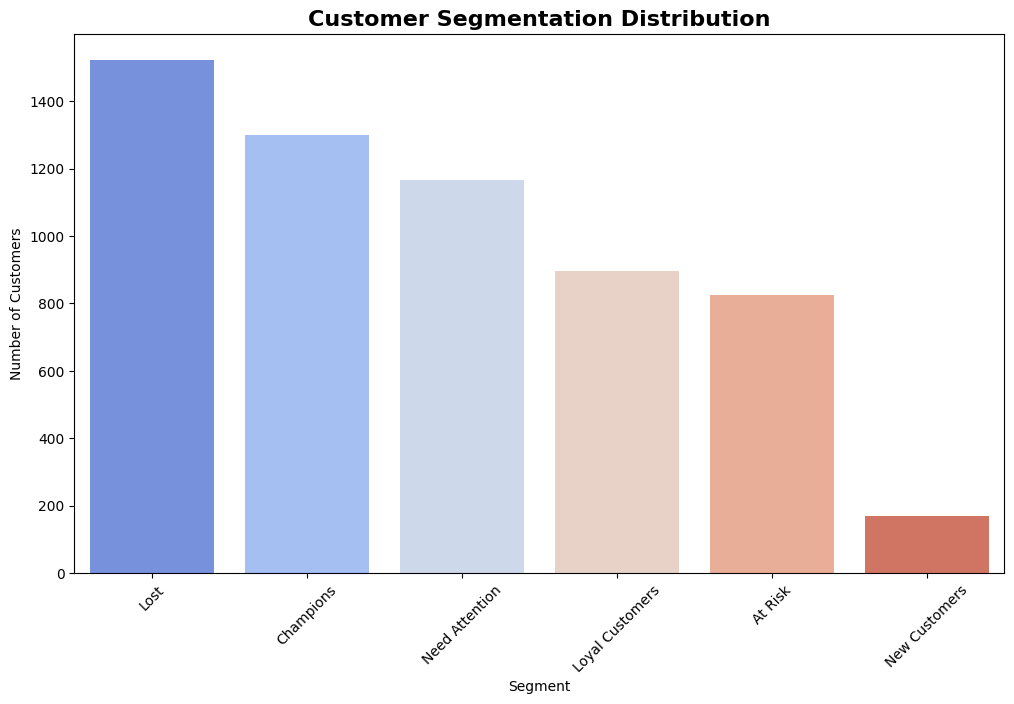

In [11]:
plt.figure(figsize=(12, 7))
segment_counts = rfm['Segment'].value_counts()

sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='coolwarm')
plt.title('Customer Segmentation Distribution', fontsize=16, fontweight='bold')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()

In [12]:
# Calculate the average spend per segment
segment_analysis = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)

display(segment_analysis)

Recency Frequency Monetary      
                   mean      mean     mean count
Segment                                         
At Risk           369.1       4.9   1983.0   824
Champions          20.0      17.1   9329.3  1300
Lost              459.3       1.3    438.0  1523
Loyal Customers    25.2       3.2   1105.1   896
Need Attention    108.2       4.9   1943.5  1167
New Customers      29.7       1.0    332.7   168

/tmp/ipython-input-1638626592.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')


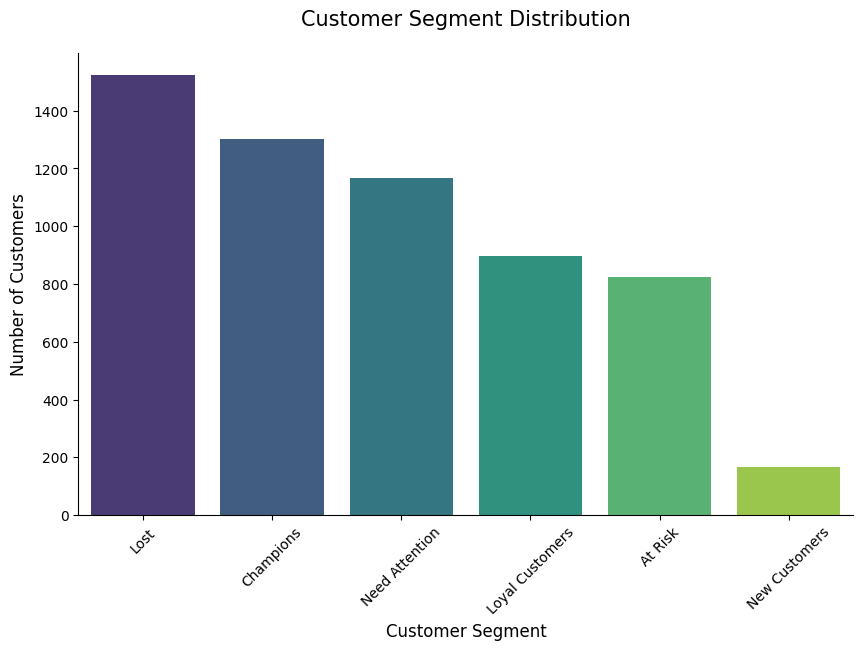

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
# Calculate counts for each segment
segment_counts = rfm['Segment'].value_counts().sort_values(ascending=False)

# Create the plot
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')

# Add titles and labels
plt.title('Customer Segment Distribution', fontsize=15, pad=20)
plt.xlabel('Customer Segment', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=45)
sns.despine() # Makes the chart look cleaner
plt.show()

In [14]:
!pip install squarify

/tmp/ipython-input-658699137.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segment_revenue, x='Segment', y='Monetary', palette='magma')


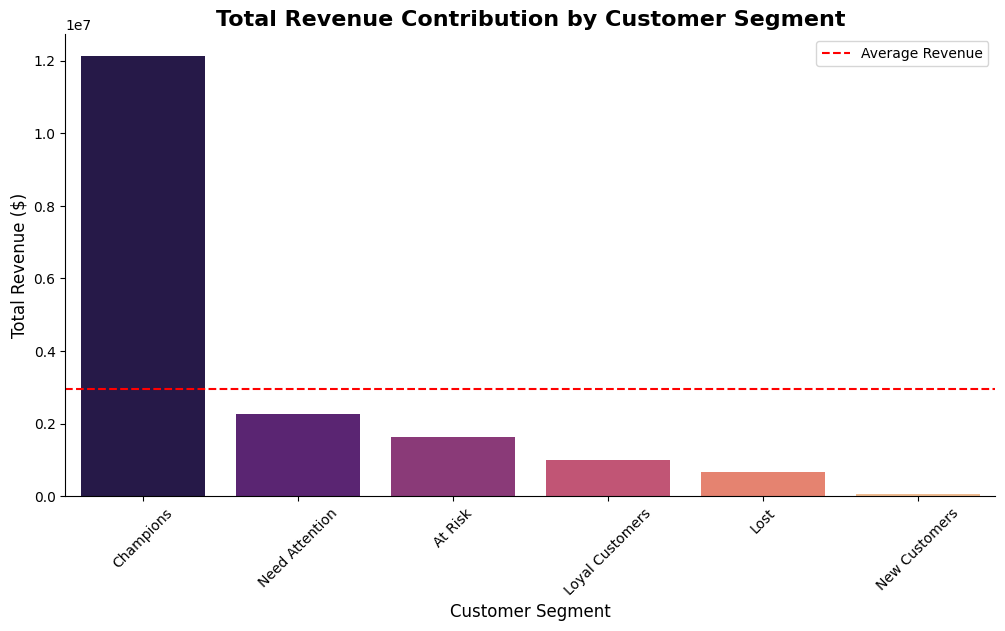

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate Revenue per Segment
segment_revenue = rfm.groupby('Segment')['Monetary'].sum().sort_values(ascending=False).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=segment_revenue, x='Segment', y='Monetary', palette='magma')

# Formatting for a professional look
plt.title('Total Revenue Contribution by Customer Segment', fontsize=16, fontweight='bold')
plt.ylabel('Total Revenue ($)', fontsize=12)
plt.xlabel('Customer Segment', fontsize=12)
plt.xticks(rotation=45)

# Add a horizontal line for the average if you want to show 'High Performers'
plt.axhline(segment_revenue['Monetary'].mean(), color='red', linestyle='--', label='Average Revenue')
plt.legend()

sns.despine()
plt.show()

In [16]:
# Calculate Average Order Value (AOV) per segment
segment_stats = rfm.groupby('Segment').agg({
    'Monetary': 'mean',
    'Frequency': 'mean'
}).round(2)

print("--- Value per Segment ---")
display(segment_stats)

--- Value per Segment ---


,Monetary,Frequency
Segment,,
At Risk,1982.98,4.94
Champions,9329.32,17.09
Lost,438.03,1.25
Loyal Customers,1105.14,3.17
Need Attention,1943.55,4.94
New Customers,332.68,1.00
